# Step 2 - Expectedness of Duplications

-- Alex Warwick Vesztrocy, November 2023

This notebook contains the code to filter the branches to only duplication events.

This is performed by computing the difference from the expected branch length and then translating this into z-scores. Branches can then be classified into two categories:
- within normal range
- unexpectedly deviating from the expected (p < 0.05)

The second category can then be split into two -- those that are unexpectedly short and those that are unexpectedly long.

In [1]:
%matplotlib inline
from collections import Counter
from scipy import stats
from scipy.special import ndtr
from tqdm.auto import tqdm
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro, normaltest


In [2]:
df = pd.read_csv('./results/expected_branches_pthr18.tsv.gz', sep='\t')

### Duplication event statistics

#### a. count after excluding the filtered branches (HGT, UNK, len==2.0)

In [3]:
dupl_ev_counter = Counter()
for (fam_id, zdf) in tqdm(df[(~df['filter_edge'])].groupby('fam_id')):
    zdf = zdf[zdf.over_duplication]
    for (dupl_ev, zzdf) in zdf.groupby(['fam_tail_idx']):
        dupl_ev_counter[fam_id] += 1

  0%|          | 0/15662 [00:00<?, ?it/s]

In [4]:
print(len(dupl_ev_counter))
sum(list(dupl_ev_counter.values()))

14105


308807

In [5]:
len(dupl_ev_counter)

14105

In [6]:
z = Counter()
for (fam_id, zdf) in tqdm(df[(~df['filter_edge'])].groupby('fam_id')):
    #zdf = zdf[zdf.over_duplication]
    for (dupl_ev, zzdf) in zdf.groupby(['fam_tail_idx']):
        z[fam_id] += 1

  0%|          | 0/15662 [00:00<?, ?it/s]

In [7]:
sum(list(z.values()))

1137926

In [8]:
len(z)

15662

#### b. count after removing those with losses immediately following the duplication

In [9]:
df1 = df[(~df['filter_edge']) & df.edge.notna()]

dupl_ev_counter1 = Counter()
for (fam_id, zdf) in tqdm(df1.groupby('fam_id')):
    zdf = zdf[zdf.over_duplication]
    for (dupl_ev, zzdf) in zdf.groupby(['fam_tail_idx']):
        dupl_ev_counter1[fam_id] += 1

  0%|          | 0/15577 [00:00<?, ?it/s]

In [10]:
sum(list(dupl_ev_counter1.values()))

280366

In [11]:
len(dupl_ev_counter1)

13597

In [12]:
dupl_per_fam = pd.DataFrame(dupl_ev_counter1.items(), columns=['fam_id', 'no_duplication_events'])

In [13]:
dupl_per_fam.to_csv('./results/tables/duplications_per_fam.tsv', sep='\t', index=False)

In [14]:
dupl_per_fam.no_duplication_events.mean()

20.619695521070824

In [15]:
len(dupl_per_fam)

13597

In [17]:
df

,fam_id,filter_edge,tail,fam_tail_idx,fam_tail_ev,head,fam_head_idx,fam_head_ev,length,over_duplication,path,edge,expected_length
0,21731,False,Euteleostomi,0,SPECIATION,Tetrapoda,1,SPECIATION,0.344,False,[220],220.0,0.287
1,21731,False,Tetrapoda,1,SPECIATION,Amniota,2,SPECIATION,0.288,False,[184],184.0,0.299
2,21731,False,Amniota,2,SPECIATION,Theria,3,SPECIATION,0.327,False,"[34, 79]",NaN,0.389
3,21731,False,Theria,3,SPECIATION,Eutheria,5,SPECIATION,0.686,True,[48],48.0,0.296
4,21731,False,Eutheria,5,SPECIATION,Euarchontoglires,6,SPECIATION,0.088,False,[64],64.0,0.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096023,47077,True,Chordata,2,SPECIATION,BRAFL,33,EXTANT_GENE,2.067,True,NaN,NaN,NaN
3096024,47077,True,Chordata,2,SPECIATION,BRAFL,34,EXTANT_GENE,2.067,True,NaN,NaN,NaN
3096025,47077,True,Chordata,2,SPECIATION,BRAFL,35,EXTANT_GENE,2.067,True,NaN,NaN,NaN
3096026,47077,False,Deuterostomia,1,SPECIATION,STRPU,36,EXTANT_GENE,0.606,False,[237],237.0,0.835


### 1 - Compute deviation from expected / z-scores

In [16]:
def compute_z_scores(df):
    # filter particular edges, compute the difference from expected and then convert this into a z score
    zdfs = []
    for (e, zdf) in tqdm(df[(~df['filter_edge']) & df['edge'].notna()].groupby('edge')):
        zdf['delta_exp'] = (zdf['length'] - zdf['expected_length'])
        zdf['delta_exp_z'] = stats.zscore(zdf['delta_exp'])

        zdfs.append(zdf)
    
    df = pd.concat(zdfs)
    # two sided test --> compute the corresponding p values.
    df['delta_exp_p'] = (1-ndtr(df['delta_exp_z'].abs()))*2
    return df

df_withz = compute_z_scores(df)

  0%|          | 0/258 [00:00<?, ?it/s]

In [17]:
print(len(set(df_withz.fam_id.values)))
df2 = df_withz[df_withz.over_duplication]
print(len(set(df2.fam_id.values)))

15577
13597


In [18]:
df_withz.to_csv('./results/tables/expected_branch_withzscore.tsv.gz', sep='\t', index=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


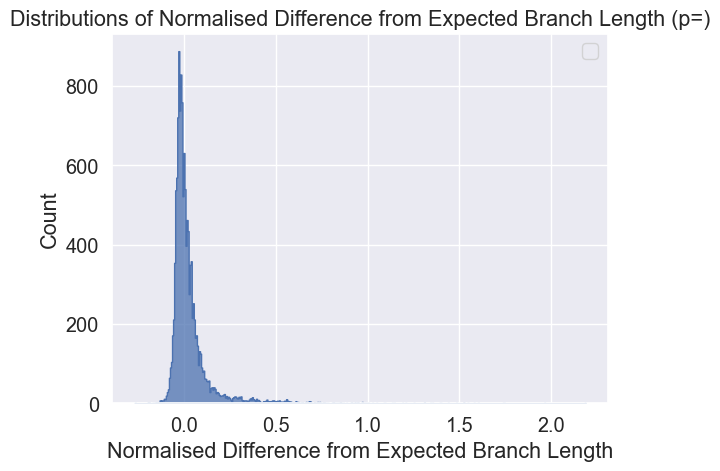

In [19]:
def plot_for_branch(df, tail, head, ax=None, split_distn=False):
    sns.set(font_scale=1.3)#, font="Arial") #style='white', "Verdana"
    if tail is None and head is None:
        zdf = df
    else:
        zdf = df[(df['tail'] == tail) & (df['head'] == head)]
    if not split_distn:    
        ax = sns.histplot(zdf['delta_exp'], ax=ax, element='step')
        ax.set_title(f'{tail}\n{head}')
        stat = None
    else:
        cols = sns.color_palette()
        a = zdf[zdf.over_duplication]['delta_exp']
        b = zdf[~zdf.over_duplication]['delta_exp']
        stat = stats.mannwhitneyu(a, b)
        ax = sns.histplot(a, color='#cd87deff', stat='density', bins=np.arange(-.5,1, 0.025), kde=False, alpha=.2, label='with duplications', element='step')
        ax = sns.histplot(b, color='#6fccffff', stat='density', bins=np.arange(-.5,1, 0.025), kde=False, alpha=.2, label='without duplications', element='step')
        print('Median','with duplication:',np.median(a),'without duplication:',np.median(b))
    
    plt.legend()
    plt.title('Distributions of Normalised Difference from Expected Branch Length (p={})'.format(stat.pvalue if stat is not None else ''))
    plt.xlabel('Normalised Difference from Expected Branch Length')    
    return ax, stat

ax = plot_for_branch(df_withz, tail='Mammalia', head='Theria')

In [27]:
# Function to check normality of data
def check_normality(data, alpha=0.05):
    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    print(f'Shapiro-Wilk Test: W={stat}, p={p}')
    
    # D'Agostino and Pearson's Test
    stat, p = normaltest(data)
    print(f'D\'Agostino-Pearson Test: K2={stat}, p={p}')
    
    if p > alpha:
        print("Data follows a normal distribution (fail to reject H0)\n")
    else:
        print("Data does not follow a normal distribution (reject H0)\n")

df_dup = df_withz[df_withz.over_duplication]['delta_exp']
df_nodup = df_withz[~df_withz.over_duplication]['delta_exp']

# Check normality
print('Expected branch with duplications')
check_normality(df_dup)

print('Expected branch without duplications')
check_normality(df_nodup)



Expected branch with duplications
Shapiro-Wilk Test: W=0.801959646888531, p=1.8664728398367383e-175
D'Agostino-Pearson Test: K2=378813.05005691573, p=0.0
Data does not follow a normal distribution (reject H0)

Expected branch without duplications
Shapiro-Wilk Test: W=0.8086974714345635, p=1.3351697370707482e-182
D'Agostino-Pearson Test: K2=472973.0246780113, p=0.0
Data does not follow a normal distribution (reject H0)



/tmp/ipykernel_209767/1026087417.py:10: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 876261.
  stat, p = shapiro(data)
/tmp/ipykernel_209767/1026087417.py:10: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1771991.
  stat, p = shapiro(data)


Median with duplication: -0.0040000000000000036 without duplication: -0.019000000000000003


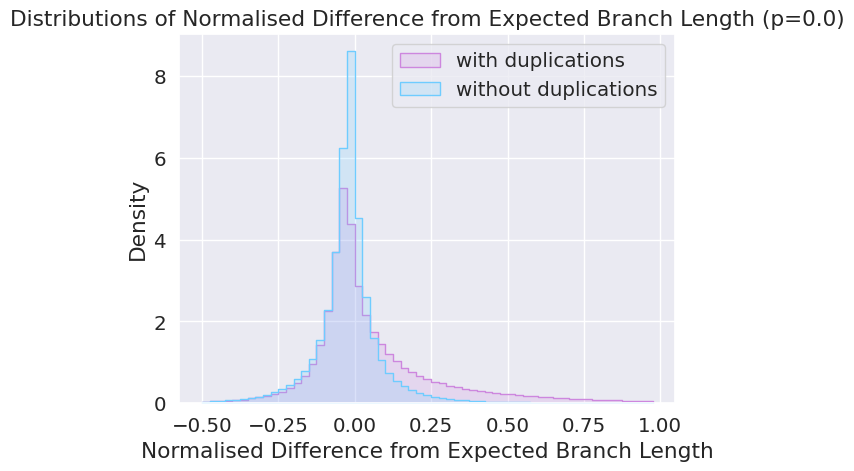

In [24]:
(ax, stat) = plot_for_branch(df_withz, tail=None, head=None, split_distn=True)
plt.savefig('results/plots/edge_delta_expected_OVERALL.svg', bbox_inches='tight')

In [29]:
stat

MannwhitneyuResult(statistic=915158288259.5, pvalue=0.0)

In [30]:
majorLinFile = 'results/tables/major_lineages_sp.txt'
major2lin = {}
for line in open(majorLinFile):
    line = line.strip()
    data = line.split('\t')
    major2lin[data[0]] = data[2].split('; ')
print(len(major2lin.keys()))
lineages = ['Protostomia', 'Deuterostomia','TRIAD','NEMVE','MONBE', 'Fungi', 'Amoebozoa', 'Excavates',
             'Viridiplantae','Alveolata-Stramenopiles','Archaea', 'Eubacteria']

12


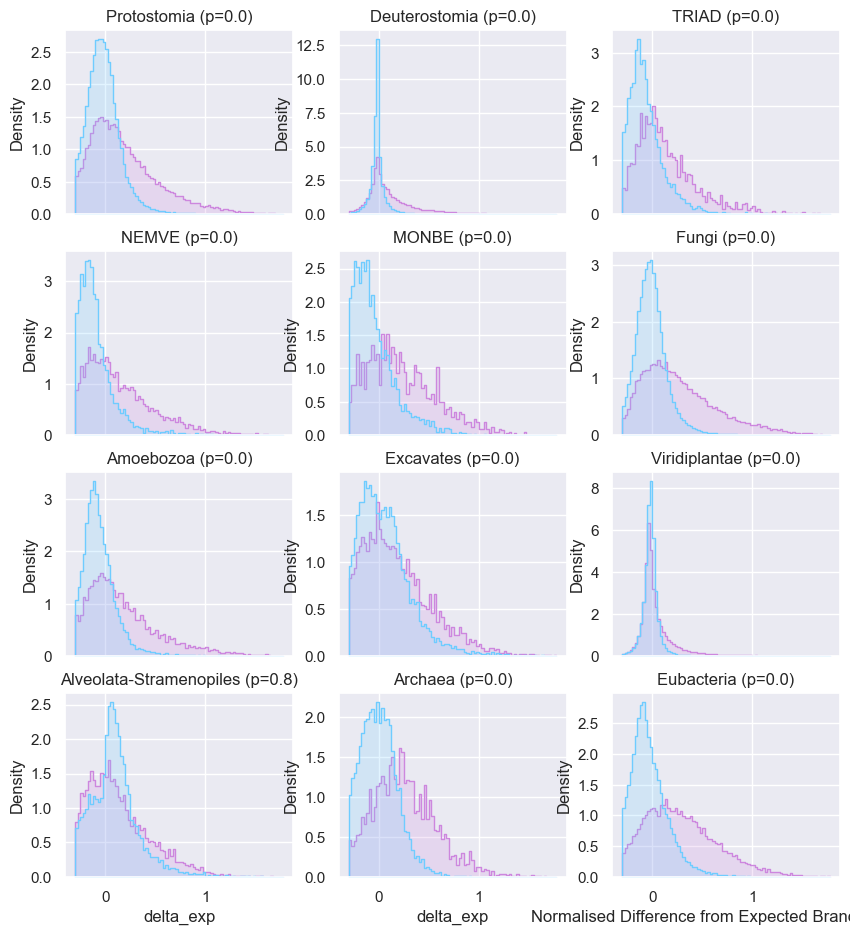

In [31]:
sns.set(font_scale=1, font="Arial") #style='white', "Verdana"
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,11), sharex=True)
axes = axes.flatten()
for i,lin in enumerate(lineages):
    df2 = df_withz[df_withz['head'].isin(major2lin[lin])]
    a = df2[df2.over_duplication]['delta_exp']
    b = df2[~df2.over_duplication]['delta_exp']
    stat = stats.mannwhitneyu(a, b)
    ax = sns.histplot(a, color='#cd87deff', stat='density', bins=np.arange(-0.3,1.8, 0.025), kde=False, alpha=.2, label='with duplications', element='step', ax=axes[i])
    ax = sns.histplot(b, color='#6fccffff', stat='density', bins=np.arange(-0.3,1.8, 0.025), kde=False, alpha=.2, label='without duplications', element='step', ax=axes[i])
    axes[i].set_title(lin +' (p='+str(round(stat.pvalue,1))+')')
plt.xlabel('Normalised Difference from Expected Branch Length')
plt.savefig('results/plots/edge_delta_expected_lineages.svg', bbox_inches='tight')
plt.show()

### 2 -- Filter to duplication events only

Now select those over duplication events only.

In [ ]:
dupl_df = df_withz[df_withz['over_duplication']].copy()

short == bottom 2.5%

long == top 2.5%

In [ ]:
dupl_df.delta_exp_p.hist()

In [ ]:
dupl_df.loc[:,'category'] = 'normal'
alpha = 0.05
short_f = (dupl_df['delta_exp_p'] < alpha) & (dupl_df['delta_exp_z'] < 0)
long_f = (dupl_df['delta_exp_p'] < alpha) & (dupl_df['delta_exp_z'] > 0)
dupl_df.loc[short_f, 'category'] = 'short'
dupl_df.loc[long_f, 'category'] = 'long'

In [ ]:
dupl_df.head()

In [ ]:
dupl_df.category.hist()

### 3 - Convert into a table defining the LDO / MDO splits at each duplication event.

In [ ]:
from lib.PantherParser import PantherTrees, EvolutionaryEvent

pt = PantherTrees(
     "./data/panther-18.0/trees/",
     taxonomy_fn="./data/panther-18.0/species_tree.nhx",
)

In [ ]:
dupl_events = []
pairs = []

removed = 0
for (fam_id, zdf) in tqdm(dupl_df.groupby('fam_id')):
    # identify the LDO pair for each group
    fam = pt.get_fam(fam_id)
    # generate the ldo groups
    ldo_groups = fam.ldo_groups

    # we have already pre-filtered to single-edge branches
    for (dupl_ev, zzdf) in zdf.groupby(['fam_tail_idx', 'edge']):
        if len(zzdf) == 1:
            # strange cases (e.g., duplication -> {extant, speciation} or {speciation, HGT})
            removed += 1
            continue

        # collect the pairs here for the LDO
        anc_grp = fam.nodes[int(dupl_ev[0])].grp
        k = 0
        for i in range(len(zzdf)):
            ii = zzdf.iloc[i]
            an_ii = fam.nodes[int(ii['fam_head_idx'])]
            
            for j in range(i+1, len(zzdf)):
                jj = zzdf.iloc[j]
                an_jj = fam.nodes[int(jj['fam_head_idx'])]
                
                if (an_ii.grp == anc_grp) or (an_jj.grp == anc_grp):
                    r = {'fam_id': fam_id,                 # panther family id
                         'fam_tail_idx': dupl_ev[0],       # shared family dupication event id
                         'sp_tree_edge': int(dupl_ev[1])}  # corresponding edge in the species tree
                    
                    if an_ii.grp == anc_grp:
                        ldo_branch = ii
                        mdo_branch = jj
                    elif an_jj.grp == anc_grp:
                        ldo_branch = jj
                        mdo_branch = ii
                    else:
                        continue

                    # add species tree branch information
                    r['sp_tree_tail'] = ldo_branch['tail']
                    r['sp_tree_head'] = ldo_branch['head']
                    assert (ldo_branch['tail'] == mdo_branch['tail']) and (ldo_branch['head'] == mdo_branch['head'])
                    
                    # add branch information
                    r['ldo_fam_head_idx'] = ldo_branch['fam_head_idx']
                    r['mdo_fam_head_idx'] = mdo_branch['fam_head_idx']

                    # add branch length
                    r['ldo_branch_length'] = ldo_branch['length']
                    r['mdo_branch_length'] = mdo_branch['length']

                    # expected branch length
                    assert (ldo_branch['expected_length'] == mdo_branch['expected_length'])
                    r['expected_branch_length'] = ldo_branch['expected_length']
                    
                    # delta expected
                    r['ldo_delta_exp'] = ldo_branch['delta_exp']
                    r['mdo_delta_exp'] = mdo_branch['delta_exp']
                    r['ldo_delta_exp_z'] = ldo_branch['delta_exp_z']
                    r['mdo_delta_exp_z'] = mdo_branch['delta_exp_z']
                    r['ldo_delta_exp_p'] = ldo_branch['delta_exp_p']
                    r['mdo_delta_exp_p'] = mdo_branch['delta_exp_p']

                    # add category
                    r['ldo_category'] = ldo_branch['category']
                    r['mdo_category'] = mdo_branch['category']

                    # index the multifurcations
                    r['multifurcation_idx'] = k
                    k += 1
                    
                    dupl_events.append(r)

                    # generate the pairwise tests also.
                    ldo_ii = ldo_groups[an_ii.grp]
                    ldo_jj = ldo_groups[an_jj.grp]
                    
                    for sp in (ldo_groups[an_ii.grp].keys() & ldo_jj.keys()):
                        r_sp = r.copy()
                        r_sp['species'] = sp
                        if an_ii.grp == anc_grp:
                            r_sp['ldo_gene'] = ldo_ii[sp]
                            r_sp['mdo_gene'] = ldo_jj[sp]
                        elif an_jj.grp == anc_grp:
                            r_sp['ldo_gene'] = ldo_jj[sp]
                            r_sp['mdo_gene'] = ldo_ii[sp]
                        else:
                            continue
                        
                        pairs.append(r_sp)


dupl_ev_df = pd.DataFrame(dupl_events)
pairs_df = pd.DataFrame(pairs)

In [ ]:
with gzip.open('./results/tables/duplication_events_with_stat.tsv.gz', 'wt') as fp:
    dupl_ev_df.to_csv(fp, sep='\t', index=False)

Total number of duplications, if taking one at random with multifurcations:

In [ ]:
(dupl_ev_df.multifurcation_idx == 0).sum()

Save the pairwise tests also.

In [ ]:
with gzip.open('./results/pairwise_tests.tsv.gz', 'wt') as fp:
    pairs_df.to_csv(fp, sep='\t', index=False)

In [ ]:
pairs_df.head()

---

## 4 -- Outgroup tests

Additionally to the pairwise testing, it is possible to test vs an outgroup extant gene. To identify these, the other branches at the speciation event prior to the duplication are followed -- taking extant genes that are the least diverged orthologues of the ancestral gene defined at the common speciation node to the studied genes.

In [ ]:
def find_speciation(fam, n_idx):
    n = fam.nodes[n_idx]
    p = n.parent_node

    while EvolutionaryEvent.identify(p) != EvolutionaryEvent.SPECIATION:
        d = p
        p = p.parent_node
        
    assert EvolutionaryEvent.identify(d) == EvolutionaryEvent.DUPLICATION

    return (p, d)


def get_outgroup_genes(fam, node_sp, node_dup):
    x = []
    for n in list(filter(lambda n: n is not node_dup, node_sp.child_nodes())):
        x += n.leaf_nodes()

    # filter the list to the same ldo group
    if not hasattr(node_sp, 'grp'):
        fam.ldo_groups
        
    ldo_grp = node_sp.grp
    ret = {}
    for g in filter(lambda n: n.grp == ldo_grp, x):
        (g_idx, g_sp) = fam.get_anx(g)
        ret[g_sp] = fam.genes[g_idx]
    return ret


def find_outgroup_gene(fam, n_idx1, n_idx2):
    (p1, d1) = find_speciation(fam, n_idx1)
    (p2, d2) = find_speciation(fam, n_idx2)
    assert p1 is p2 and d1 is d2
    return get_outgroup_genes(fam, p1, d1)


def generate_pair_outgroup_table(pt, df, species=None):
    fams = {fam.id: fam for fam in pt.iter_fams()}
    
    def gen():
        for (_, r) in tqdm(df.iterrows(), total=len(df)):
            x = find_outgroup_gene(fams[r['fam_id']], r['ldo_fam_head_idx'], r['mdo_fam_head_idx'])
            yield dict(r) | {f'outgroup_ldo_{k}': v['UniProtKB'] for (k, v) in x.items() if species is None or k in species}

    df1 = pd.DataFrame(gen())
    header = list(df.keys())
    header += sorted(list(df1.keys())[len(header):])
    return df1[header]

In [ ]:
pairs_out_df = generate_pair_outgroup_table(pt, pairs_df)

pairs_out_df.to_csv('./results/outgroup_tests.tsv.gz', sep='\t', index=False)

---

## Categorisation of pairwise tests

Look at the number of tests that are in each category, irrespective of whether we can perform a test or not.

In [ ]:
cats = pairs_out_df.apply(lambda x: '_'.join((x['ldo_category'], x['mdo_category'])), axis=1)

In [ ]:
cat_counts = Counter(cats)

In [ ]:
x = ['short_short',
     'short_normal',
     'short_long',
     'normal_normal',
     'normal_long',
     'long_long']
y = list(map(lambda x: cat_counts[x], x))

In [ ]:
x

In [ ]:
y

In [ ]:
ax = sns.barplot(x=x,y=y)
plt.xticks(rotation=45)
plt.title('No. Duplication Events per-Category')
plt.ylabel('Count')
plt.xlabel('Category')